In [3]:
from data_loader import load_cifar, load_mnist

data = load_mnist()

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Assuming 'data' is loaded from a previous cell
train_data = data['train']

# Get the first instance
instance = train_data[0]

print("Fields in the first data instance:")
for key, value in instance.items():
    print(f"{key}:")
    # Print the value, but handle large arrays like images gracefully
    if isinstance(value, (list, np.ndarray)) and len(value) > 10:
         print(f"  Type: {type(value)}, Shape: {np.shape(value) if isinstance(value, np.ndarray) else len(value)}")
    else:
        print(f"  {value}")


Fields in the first data instance:
image:
  Type: <class 'numpy.ndarray'>, Shape: (28, 28)
label:
  5


Displaying 2 examples from the MNIST training set:


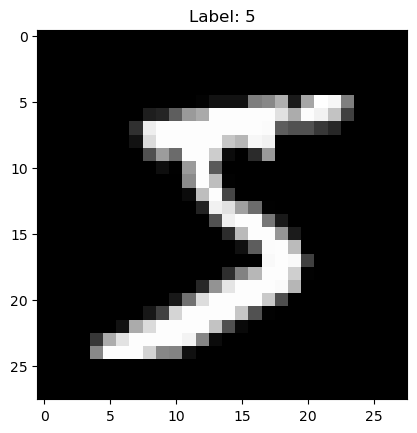

Example 1: Label = 5


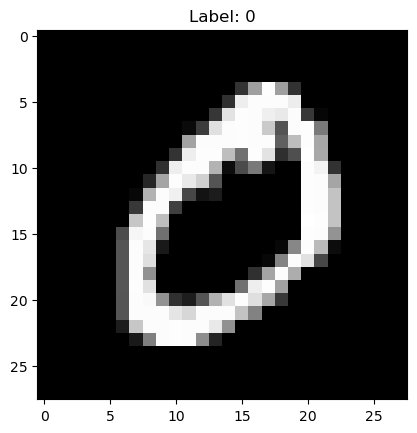

Example 2: Label = 0


In [14]:
# Assuming 'data' is loaded from the previous cell
train_data = data['train']

print("Displaying 2 examples from the MNIST training set:")
for i in range(2):
    instance = train_data[i]
    image_matrix = instance['image']
    image_label = instance['label']

    plt.imshow(image_matrix, cmap='gray')
    plt.title(f"Label: {image_label}")
    plt.show()
    print(f"Example {i+1}: Label = {image_label}")


In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [23]:
# Assuming 'data' is loaded from a previous cell and CNN class is defined

# Prepare the data
def prepare_data(raw_data, batch_size=64):
    images = np.array([item['image'] for item in raw_data]).astype(np.float32)
    labels = np.array([item['label'] for item in raw_data]).astype(np.int64)

    # Reshape images to (N, C, H, W) -> (N, 1, 28, 28) for MNIST
    images = images.reshape(-1, 1, 28, 28)
    
    # Normalize images (0-1 range)
    images /= 255.0 
    
    tensor_images = torch.from_numpy(images)
    tensor_labels = torch.from_numpy(labels)
    
    dataset = TensorDataset(tensor_images, tensor_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

train_loader = prepare_data(data['train'])
test_loader = prepare_data(data['test'])

# Instantiate the model, optimizer, and loss function
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    epoch_losses = []
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_totoal_loss = 0.0
        num_batches = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_totoal_loss += loss.item()
            loss_history.append(loss.item())
            num_batches += 1
            
            if batch_idx % 100 == 99: # Print every 100 batches
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0
        avg_loss = epoch_totoal_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")
    print("Finished Training")
    return epoch_losses, loss_history

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")
    return accuracy

# Run training and evaluation
print("Starting training...")
epoch_losses, loss_history = train_model(model, train_loader, criterion, optimizer, epochs=5)
print("\nStarting evaluation...")
evaluate_model(model, test_loader)

Starting training...
Epoch [1/5], Batch [100/938], Loss: 0.8003
Epoch [1/5], Batch [200/938], Loss: 0.2214
Epoch [1/5], Batch [300/938], Loss: 0.1394
Epoch [1/5], Batch [400/938], Loss: 0.1241
Epoch [1/5], Batch [500/938], Loss: 0.1071
Epoch [1/5], Batch [600/938], Loss: 0.0948
Epoch [1/5], Batch [700/938], Loss: 0.0788
Epoch [1/5], Batch [800/938], Loss: 0.0850
Epoch [1/5], Batch [900/938], Loss: 0.0698
Epoch [1/5], Average Loss: 0.1858
Epoch [2/5], Batch [100/938], Loss: 0.0699
Epoch [2/5], Batch [200/938], Loss: 0.0565
Epoch [2/5], Batch [300/938], Loss: 0.0624
Epoch [2/5], Batch [400/938], Loss: 0.0510
Epoch [2/5], Batch [500/938], Loss: 0.0538
Epoch [2/5], Batch [600/938], Loss: 0.0503
Epoch [2/5], Batch [700/938], Loss: 0.0461
Epoch [2/5], Batch [800/938], Loss: 0.0489
Epoch [2/5], Batch [900/938], Loss: 0.0406
Epoch [2/5], Average Loss: 0.0529
Epoch [3/5], Batch [100/938], Loss: 0.0348
Epoch [3/5], Batch [200/938], Loss: 0.0369
Epoch [3/5], Batch [300/938], Loss: 0.0363
Epoch [3

99.02

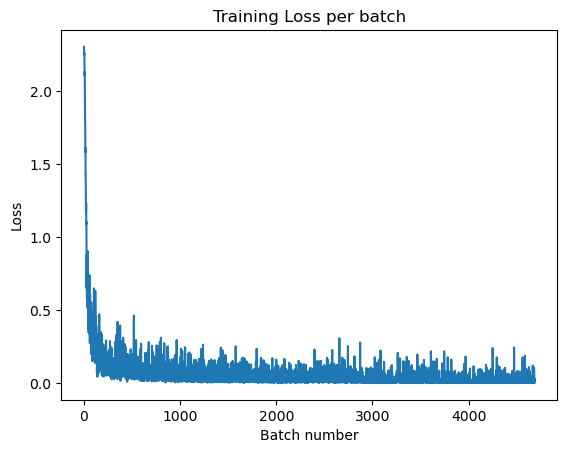

In [24]:
plt.figure()
plt.plot(loss_history)
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Training Loss per batch')
plt.show()

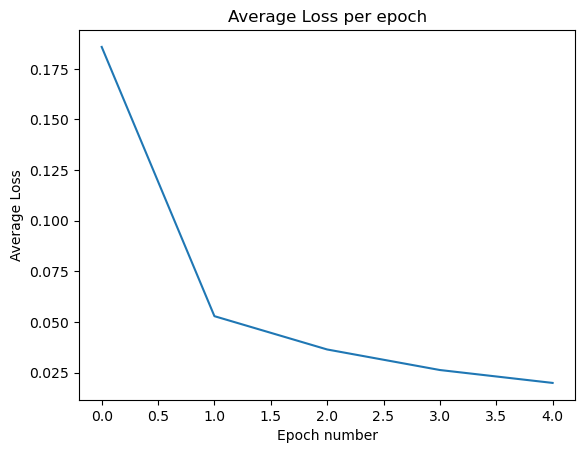

In [25]:
plt.figure()
plt.plot(epoch_losses)
plt.xlabel('Epoch number')
plt.ylabel('Average Loss')
plt.title('Average Loss per epoch')
plt.show()